# Стохастический анализ (2025)
# Домашнее Задание 1 (программная часть)

ВАШЕ ИМЯ ЗДЕСЬ

Оценка(итоговая за ДЗ): ?? из 100 + бонус(?)


Задачи: ?? из 50

Ноутбук: ?? из 50


Дедлайн:  13 февраля 2359МСК

Решённый ноутбук нужно засабмитить в Anytask курса

Пожалуйста, называйте файл(ы) в формате <Имя>HW1.pdf или <Имя>HW1.ipynb. Например, KaledinHW1.pdf и KaledinHW1.ipynb.

In [367]:
#all imports here, please
import numpy as np
import sklearn.linear_model as sklin
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import pandas as pd
from sklearn.metrics import mean_squared_error
import random
import sklearn.linear_model as sklin
from scipy.stats import norm

import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots


## Часть 1: Оценка параметров в модели Блэка-Шоулза (20 баллов)

В одной из первых классических финансовых моделей цены акций моделируются с помощью процесса геометрического Броуновского движения (GBM). Пусть $(W_t)_{t \in \mathbb{R}_+}$ -- Винеровский процесс, тогда процесс геометрического Броуновского движения задаётся как

$$
X_t = X_0 e^{(\mu-\sigma^2/2)t + \sigma W_t},
$$

$\mu$ -- параметр сноса (связан с безрисковой процентной ставкой),  $\sigma$ -- параметр волатильности (показывающий насколько интенсивно цена может колебаться, связан с активностью инвесторов). Ваша задача в этом упражнении построить первую модель для оценки параметров по имеющейся дискретной реализации процесса.

### Вывод формул для параметров

Пусть даны $X_0,X_{t_1}..,X_{t_n}$ -- часть траектории процесса, мы хотим подогнать параметры $\mu,\sigma$ в предположении, что наблюдения пришли из геометрического Броуновского движения. Обычная регрессия в данном случае нам не подойдёт, так как мы имеем дело с нелинейной моделью и наблюдения $X_i$ зависимы. Но можно выписать функцию правдоподобия, если вспомнить, что логарифмы

$$
    \ln \frac{X_t}{X_{t-1}}
$$
 
независимы.

#### Функция правдоподобия

Пусть даны $t_0=0,t_1,..,t_n$ и $X_0,X_1,..,X_n$ (например, данные собранные на бирже). Выпишите функцию правдоподобия $L(\mu,\sigma)$ для модели, возьмите в конце логарифм, так как с ним будет удобнее работать.

Введем обозначение логарифмической доходности:

$Y_i = \ln \frac{X_{t_i}}{X_{t_{i-1}}} = \ln X_{t_i} - \ln X_{t_{i-1}} = (\mu-\sigma^2/2)(t_i - t_{i-1}) + \sigma(W_{t_i} - W_{i-1})$

Заметим, что $W_{t_i} - W_{i-1} \sim \mathcal{N}(0, t_i - t_{i-1})$, так как $W_{t_i}$ -- Винеровский процесс.

Получаем, что $Y_i$ построен с помощью линейного преобразования Винеровского процесса (процесса, имеющего нормальное распределение). Значит, $Y_i$ также имеет нормальное распределение.

$\mathbb{E}[Y_i] = (\mu-\sigma^2/2)(t_i - t_{i-1}) + 0 = (\mu-\sigma^2/2)(t_i - t_{i-1})$

$Var [Y_i] = Var(W_{t_i}) + Var(W_{i-1}) - 2cov(W_{t_i}, W_{i-1}) = \sigma^2 (t_i - t_{i-1}) $

Отсюда, $Y_i \sim \mathcal{N} \left( \left(\mu - \frac{\sigma^2}{2} \right) (t_i - t_{i-1}), \sigma^2 (t_i - t_{i-1}) \right)$


Так как инвестор максимизирует прибыль, функция правдоподобия будет учитывать суммарный выигрыш инвестора, формирующийся из доходностей по бумагам ($Y_i$):

$L(\mu, \sigma) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi \sigma^2 (t_i - t_{i-1})}} \exp \left( -\frac{\left( Y_i - (\mu - \sigma^2/2)(t_i - t_{i-1}) \right)^2}{2\sigma^2 (t_i - t_{i-1})} \right)$

Возьмем логарифм функции правдоподобия, так как монотонное преобразование не повлияет на ее максимум:

$\ln L(\mu, \sigma) = -\frac{1}{2} \sum_{i=1}^{n} \ln (2\pi \sigma^2 (t_i - t_{i-1})) - \sum_{i=1}^{n} \frac{\left( Y_i - (\mu - \sigma^2/2)(t_i - t_{i-1}) \right)^2}{2\sigma^2 (t_i - t_{i-1})}$

#### Вычисление производных

Вычислите производные функции $\ln L(\mu,\sigma)$.

Не мудрствуя лукаво, возьмем производные по каждой из переменных:

$\partial_\mu \ln L = \sum_{i=1}^{n} \frac{(t_i - t_{i-1}) (Y_i - (\mu - \sigma^2/2)(t_i - t_{i-1}))}{\sigma^2 (t_i - t_{i-1})}  = \sum_{i=1}^{n} \frac{(Y_i - (\mu - \sigma^2/2)(t_i - t_{i-1}))}{\sigma^2}$

$\partial_{\sigma^2} \ln L = -\sum_{i=1}^{n} \frac{(t_i - t_{i-1})}{\sigma^2} + \sum_{i=1}^{n} \frac{(Y_i - (\mu - \sigma^2/2)(t_i - t_{i-1}))^2}{\sigma^4 (t_i - t_{i-1})}$


#### Запись формул для $\mu,\sigma$

Найдите $\mu,\sigma$, приравняв производные к нулю (в этих точках функция действительно будет иметь максимум, проверяется вычислением матрицы Гессе, но здесь это делать не нужно).

Приравняем $\partial_\mu \ln L$ к нулю:

$\sum_{i=1}^{n} \frac{(t_i - t_{i-1}) \left( Y_i - (\mu - \sigma^2/2)(t_i - t_{i-1}) \right)}{\sigma^2 (t_i - t_{i-1})} = 0$

Получаем:

$\mu - \frac{\sigma^2}{2} = \frac{1}{\sum_{i=1}^{n} (t_i - t_{i-1})} \sum_{i=1}^{n} Y_i$

Значит:

$\mu = \frac{1}{\sum_{i=1}^{n} (t_i - t_{i-1})} \sum_{i=1}^{n} Y_i + \frac{\hat{\sigma}^2}{2}$

Приравняем $\partial_\sigma^2 \ln L$ к нулю:

$\sum_{i=1}^{n} \frac{(Y_i - (\mu - \sigma^2/2)(t_i - t_{i-1}))^2}{\sigma^4 (t_i - t_{i-1})} - \sum_{i=1}^{n} \frac{(t_i - t_{i-1})}{\sigma^2} = 0$

Домножим на $\sigma^4$ :

$\sum_{i=1}^{n} (Y_i - (\mu - \sigma^2/2)(t_i - t_{i-1}))^2 = \sigma^2 \sum_{i=1}^{n} (t_i - t_{i-1})$

Подставим оптимальное $\mu$ и выразим $\mu$ и $\sigma^2$:

$$
\hat{\mu} = \frac{1}{\sum_{i=1}^{n} (t_i - t_{i-1})} ( \sum_{i=1}^{n} [\frac{(X_i - \bar{X})^2}{2n}] + \bar{X})
$$

$$
\hat{\sigma}^2 = \frac{1}{n \sum_{i=1}^{n} (t_i - t_{i-1})} \sum_{i=1}^{n} (X_i - \bar{X})^2
$$

### Воплощение в коде

Теперь имплементируйте модель оценки, используйте для основы код ниже. Нам также понадобится код для симуляции Винеровского процесса.

In [368]:
def simulateWienerProcess(x0,ts,Ntraj):
    '''
    Simulates trajectories of Wiener process
    Input
    float x0 -- initial value
    float[] ts -- times
    int Ntraj -- number of trajectories to simulate
    Returns
    float[] of shape (Ntraj,len(ts))
    '''

    dt = np.diff(ts, prepend=0)  
    xi = np.random.normal(0, 1, (Ntraj, len(ts)))

    dW = np.sqrt(dt)* xi
    xs = x0 + np.cumsum(dW, axis=1) 
        
    return xs

class GBMModel:
    '''
        Implements Geometric Brownian Motion, allowing for parameter estimation and simulations
    '''

    def __init__(self, mu=0,sigma=1):
        '''
        Input
        float mu -- drift parameter (if pre-defined)
        float sigma -- volatility (if pre-defined)
        '''
        self.mu=mu
        self.sigma=sigma


    def fit(self, xs, ts):
        '''
        Fits the parameters to the given time series
        Input
        float[] xs -- observations
        float[] ts -- times (same shape as xs)
        '''
        dt = np.diff(ts)
        log_returns = np.diff(np.log(xs))

        self.mu = np.sum(log_returns / dt) / np.sum(1 / dt)
        self.sigma = np.sqrt(np.sum((log_returns - self.mu * dt) ** 2 / dt) / np.sum(1 / dt))

        
    def simulate(self,x0,ts,Ntraj):
        '''
        Simulates trajectories of GBM with set mu and sigma
        Input
        float x0 -- initial price
        float[] ts -- times
        int Ntraj -- number of trajectories to simulate
        Returns
        float[] of shape (Ntraj,len(ts))
        '''

        W = simulateWienerProcess(0, ts, Ntraj)
        t = np.array(ts).reshape(1, -1) 

        drift = (self.mu - 0.5 * self.sigma**2) * t  
        return x0 * np.exp(drift + self.sigma * W)  

        #For confidence intervals use the exponentiated gaussian intervals of (mu-sigma^2/2)t + sigma W_t

    def predict(self,x0,ts):
        '''
        Makes a prediction based on the fact that at ts[0] the process value equals x0
        Input
        float x0 -- initial price
        float[] ts -- times for predictions
        Returns
        float[] preds, float[] confIntLows, float[] confIntHigh
        predictions (len(ts)), confIntLows (len(ts)), confIntHighs (len(ts))
        '''
        t = np.array(ts)
        mean = (self.mu - 0.5 * self.sigma**2) * t
        std = self.sigma * np.sqrt(t)

        prediction = x0 * np.exp(mean)

        confIntLows = x0 * np.exp(mean - 1.96 * std)
        confIntHighs = x0 * np.exp(mean + 1.96 * std) 

        return prediction, confIntLows, confIntHighs
        

В качестве теста, попробуйте нарисовать траектории Винеровского процесса и траектории геометрического броуновского движения для данных ниже.

In [369]:
ts = np.linspace(0,5,100)

Ntraj=10
x0=5

wienTrajs = simulateWienerProcess(0,ts,Ntraj)

gbm = GBMModel()
gbmTrajs = gbm.simulate(x0,ts,Ntraj)


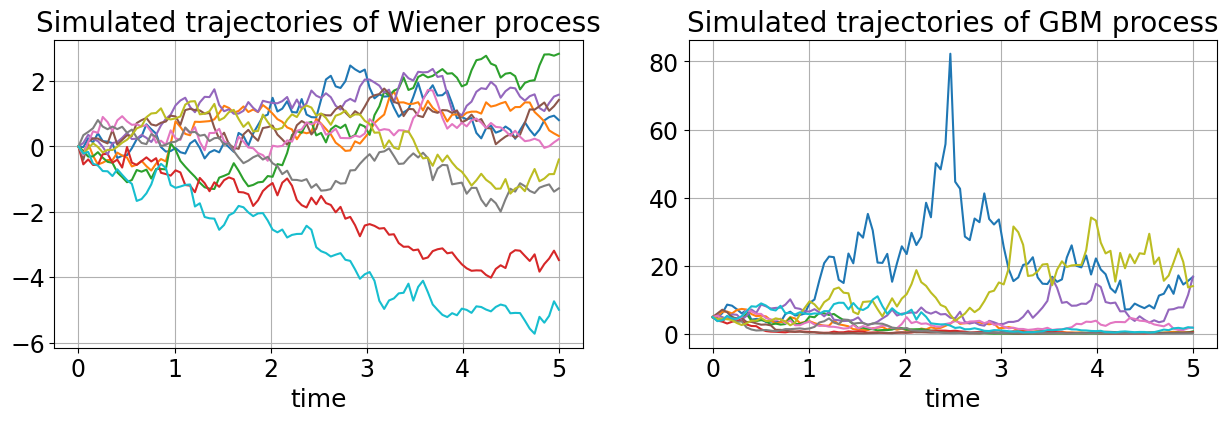

In [370]:
#plots
# wienTrajs = wienTrajs.squeeze()
# gbmTrajs = gbmTrajs.squeeze()

f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))

ax1.grid()
ax1.set_title('Simulated trajectories of Wiener process',fontsize=20)
ax1.set_xlabel('time',fontsize=18)
ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax1.plot(ts,wienTrajs.T)

ax2.grid()
ax2.set_title('Simulated trajectories of GBM process',fontsize=20)
ax2.set_xlabel('time',fontsize=18)
ax2.tick_params(axis='x', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)
ax2.plot(ts,gbmTrajs.T)


### Подгонка параметров GBM под данные

Загрузите датасет gbmData.pkl, который идёт вместе с ноутбуком и попробуйте оценить модель геометрического Броуновского движения для него. Нарисуйте график, на котором указаны точки данных, матожидание полученного процесса и доверительный интервал; пунктиром нарисуйте несколько реализаций процесса геометрического Броуновского движения.

In [371]:
with open("gbmData.pkl", "rb") as file:
    data = pickle.load(file)

print(type(data))
print(data)

<class 'dict'>
{'ts': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6

In [372]:
ts_data = data['ts']
prices_data = data['prices']

gbm_data = GBMModel()
gbm_data.fit(prices_data, ts_data)
print("Параметры модели:")
print("mu:", gbm_data.mu)
print("sigma", gbm_data.sigma)

Параметры модели:
mu: 0.002251288615764619
sigma 0.01636624647239804


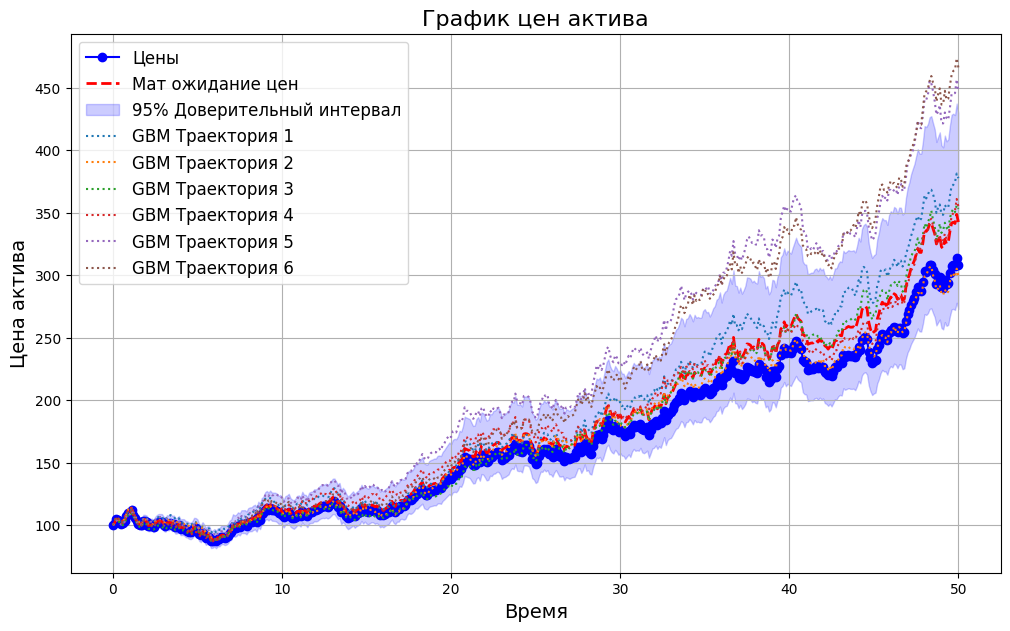

In [373]:
expected_prices, confIntLows, confIntHighs = gbm_data.predict(prices_data, ts_data)
Ntraj = 6
gbm_simulation = gbm_data.simulate(prices_data, ts_data, Ntraj)

f,ax = plt.subplots(figsize=(12,7))

ax.plot(ts_data, prices_data, marker='o', linestyle='-', color='b', label="Цены")
ax.plot(ts_data, expected_prices, linestyle='--', color='red', linewidth=2, label="Мат ожидание цен")
ax.fill_between(ts_data, confIntLows, confIntHighs, color="blue", alpha=0.2, label="95% Доверительный интервал")

for i in range(Ntraj):
    ax.plot(ts_data, gbm_simulation[i], linestyle='dotted', linewidth=1.5, label=f"GBM Траектория {i+1}")


ax.set_xlabel("Время", fontsize=14) 
ax.set_ylabel("Цена актива", fontsize=14) 
ax.set_title("График цен актива", fontsize=16)
ax.legend(fontsize=12)
ax.grid(True) 

plt.show()

урааа, построили вполне симпатичный график :)

### Проверка качества предсказаний

Проверим, как хорошо делаются предсказания в полученной модели. Для этого обучите модель на первых $60\%$ ряда, а оставшиеся оставьте для тестов. Попробуйте в разных местах обучающей и тестовой части ряда предсказать следующие 50 наблюдений на основе текущего.

Наилучший в смысле среднеквадратической ошибки прогноз -- это условное матожидание

$$
\mathbb{E}[X_{t+h} \vert X_t] = X_t \mathbb{E}[ e^{(\mu - \sigma^2/2)h + \sigma W_h} ].
$$


Процесс Марковский(как увидим позднее), поэтому предыдущая история не важна. Сравните предсказания GBMModel и тестовые значения, нарисуйте доверительные интервалы для среднего, которые выдаёт оценённая модель (можно их построить для прогноза логарифма, а потом взять экспоненту). Насколько модель подходит для короткосрочного и долгосрочного прогноза?

In [374]:
df = pd.DataFrame({
    "ts": ts_data,
    "prices": prices_data,
})

df.head()

,ts,prices
0,0.0,100.000000
1,0.1,101.810333
2,0.2,105.010275
3,0.3,104.236542
4,0.4,102.645044


In [375]:
tf_train, tf_test = train_test_split(
    df, test_size=0.4, random_state=42, shuffle=False)

In [376]:
gbm_model = GBMModel()

gbm_model.fit(tf_train["prices"].values, tf_train["ts"].values)

print(f"Оценённое mu: {gbm_model.mu:.5f}")
print(f"Оценённое sigma: {gbm_model.sigma:.5f}")


Оценённое mu: 0.00187
Оценённое sigma: 0.01680


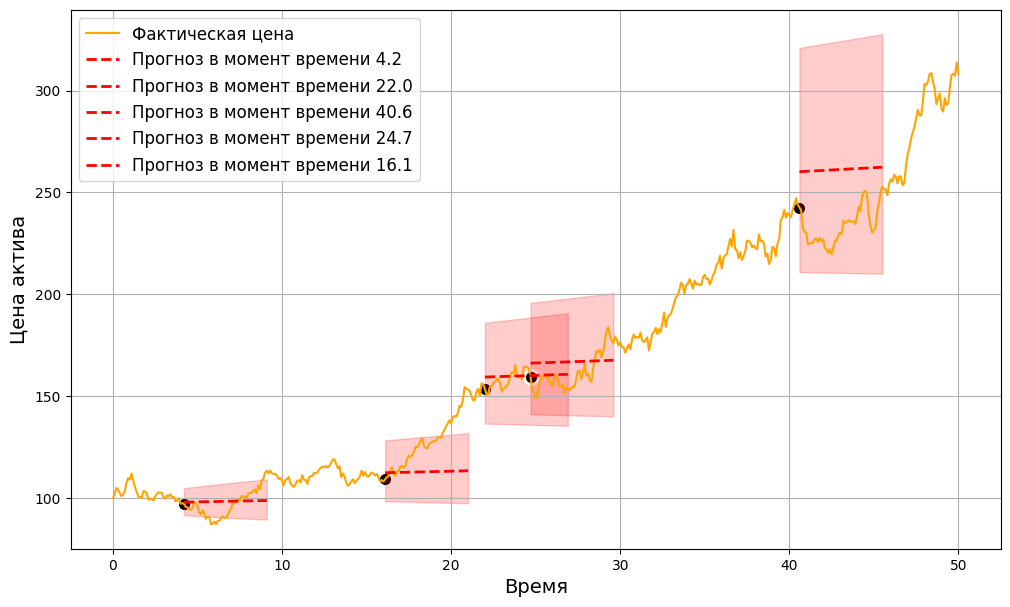

In [377]:
num_predictions = 5
observations = 50
random_numbers = random.sample(range(0, len(df['ts'].values) - observations - 1), num_predictions) 
pred_dict={}

f, ax = plt.subplots(figsize=(12, 7))
ax.set_xlabel("Время", fontsize=14)
ax.set_ylabel("Цена актива", fontsize=14)
ax.plot(df["ts"], df["prices"], linestyle='-', color='orange', label="Фактическая цена")


for i in random_numbers:
    x0 = df["prices"].values[i]
    ts_future = df["ts"].iloc[i:i + observations].values

    f_pred, f_Lows, f_Highs = gbm_model.predict(x0, ts_future)

    ax.scatter(ts_future[0], x0, color='black', s=100, edgecolors='white', linewidth=2)
    ax.plot(ts_future, f_pred, linestyle='dashed', color='red', linewidth=2, label=f"Прогноз в момент времени {ts_future[0]:.1f}")
    ax.fill_between(ts_future, f_Lows, f_Highs, color='red', alpha=0.2)


ax.legend(fontsize=12)
ax.grid(True)


Покажем наши предсказания на только тестовой выборке:

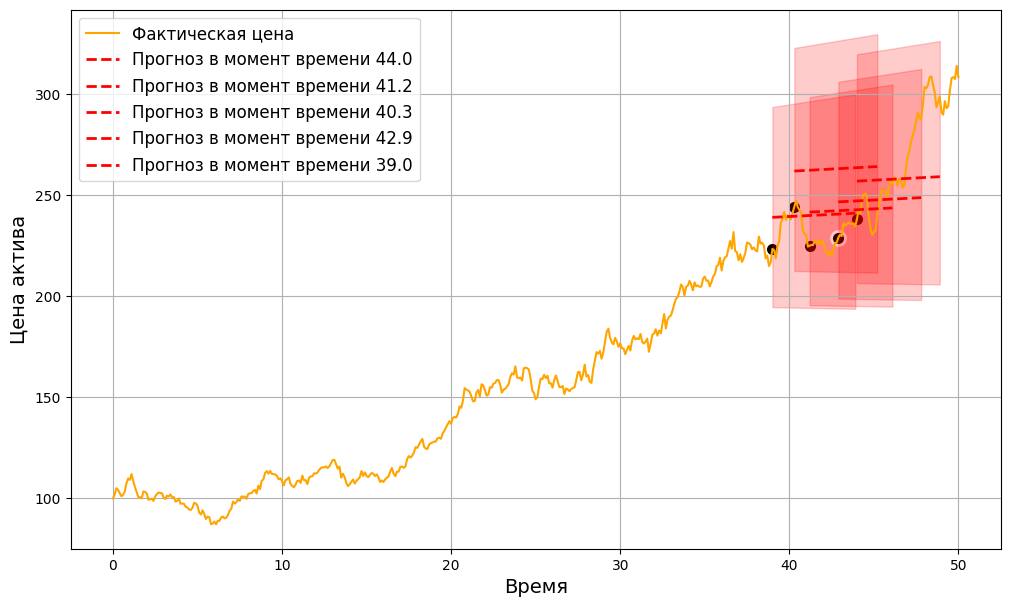

In [378]:
num_predictions = 5
observations = 50
random_numbers = random.sample(range(0, len(tf_test['ts'].values) - observations - 1), num_predictions) 
pred_dict={}

f, ax = plt.subplots(figsize=(12, 7))
ax.set_xlabel("Время", fontsize=14)
ax.set_ylabel("Цена актива", fontsize=14)
ax.plot(df["ts"], df["prices"], linestyle='-', color='orange', label="Фактическая цена")


for i in random_numbers:
    x0 = tf_test["prices"].values[i]
    ts_future = tf_test["ts"].iloc[i:i + observations].values

    f_pred, f_Lows, f_Highs = gbm_model.predict(x0, ts_future)

    ax.scatter(ts_future[0], x0, color='black', s=100, edgecolors='white', linewidth=2)
    ax.plot(ts_future, f_pred, linestyle='dashed', color='red', linewidth=2, label=f"Прогноз в момент времени {ts_future[0]:.1f}")
    ax.fill_between(ts_future, f_Lows, f_Highs, color='red', alpha=0.2)


ax.legend(fontsize=12)
ax.grid(True)


Анализируя график, нетрудно заметить, что модель дает наиболее точные прогнозы на краткосрочные сделки. При увеличении количества прогнозируемых объектов, точность уменьшается.

#### Комментарий

Если говорить о математических и вычислительных аспектах, то можно попробовать задать модель и попробовать её с нуля обучить на своей траектории. Увидим, что в нашей модели есть как минимум одна проблема, которая неочевидна с первого взгляда, но почти сразу возникает на практике. Константная волатильность оценивается очень качественно, но параметр сноса очень неустойчивый. Поэтому если на вход приходит не очень удачная (нередкость)  последовательность наблюдений, то снос оценивать сложнее. 

## Часть 2: Задача оценки американского опциона (30 баллов)

### Постановка задачи

Американский опцион даёт право на продажу(put) или покупку(call) актива (или корзины из нескольких активов) по цене страйка $K$ в любой момент времени от $0$ (сейчас) до времени истечения $T$. В классической модели Блека-Шоулза есть безрисковый банковский счёт ставке $r\%$ годовых, а для моделирования цен акций с дивидендами $\delta\%$ годовых используется геометрическое Броуновское движение с параметрами сноса $\mu=r-\delta$ и волатильности $\sigma$. Для простоты в этой задаче мы положим что волатильности $\sigma_i$, дивиденды $\delta_i$ и начальные цены $x_0^i$ у акций отличаются, но цены моделируются как

$$
X^i_t = x_0^i e^{(r-\delta_i - \sigma_i^2/2)t + \sigma_i W^i_t},
$$

где Винеровские процессы $(W^i_t)_{t \in \mathbb{R}_+}$ некоррелированы, то есть, $(W_t)_{t \in \mathbb{R}_+}$ - это $d$-мерный Винеровский процесс.

Из лекций мы знаем, как определяется честная цена европейского опциона, в случае американского идея та же: честная цена равна выгоде, которую можно получить от наилучшего использования опциона. Так как американский опцион можно исполнить в любой момент, то честная цена вычисляется из решения задачи оптимальной остановки:

$$
\max_{\tau \in \Tau} \mathbb{E}\left[ e^{-r\tau}f(X_\tau)\right],
$$

где $f$ -- это функция выплаты опциона, к примеру, $f(x)=(\sum_{i=1}^d x^i - K)_+$, $\tau$ -- это момент остановки, а $\Tau$ -- множество всех возможных времён остановки. Время остановки в данном случае себе проще представлять как решающее правило, которое говорит, когда опцион нужно исполнить, а когда -- подождать ещё. 

Ваша задача состоит в том, чтобы реализовать приближённый метод для оценки американского опциона.


### Описание метода


Для приближённой оценки опциона численными методами, задачу дискретизируют, рассматривая так называемый бермудский опцион, который можно исполнять в моменты $t_k=k\Delta$, где $\Delta=T/p, k=0,..,p$. Для решения этой задачи уже можно пользоваться принципом Беллмана (динамическим программированием). Определим функцию ценности $V_p(x)=f(x)$; действительно, если мы находимся в момент истечения, то опцион сгорает, если мы его не исполнили и приносит прибыль иначе. Более ранние функции ценности строятся рекурсивно: функция ценности 

$$
V_{t_k}(x) = f(x) \vee \left\lbrace e^{-r(t_{k+1}-t_k)} \mathbb{E}\left[ V_{t_{k+1}}(X_{t_{k+1}}) ~\vert~ X_{t_k}=x\right] \right\rbrace,
$$

где значок $\vee$ обозначает максимум из значения слева и справа. Функция $V_0(x)$ будет, таким образом, честной ценой бермудского опциона при условии текущих цен $X_0=x$.

#### Смещённая вверх оценка (High-Biased Estimator)

Один из подходов может состоять в следующем (Longstaff,Shwarz 2001): на каждом шаге мы решаем задачу регрессии, пытаясь предсказывать

$$
\mathbb{E}\left[ V_{t_{k+1}}(X_{t_{k+1}}) ~\vert~ X_{t_k}=x\right]
$$
по $X_{t_k}$. Чтобы это реализовать мы из момента $t_0$ семплируем независимо $N$ траекторий из модели $(X_t)$, обозначим траекторию $i$ индексом наверху $X_t^i$. В конце мы задаём вектор

$$
    v_p = (V_p(X_p^i)) = (f(X_p^i)), ~~~ i=1,..,N.
$$

Далее на следующих шагах $k-1<p$ мы обучаем некоторую предсказательную модель $\hat{V}_{k-1}: \mathbb{R}^d \to \mathbb{R}$, которая может предсказать по $X_{t_{k-1}}$ значение ожидаемого выигрыша, $V(X_{t_{k}})$ и задаём вектор

$$
    v_{k-1} = (f(X_{t_{k-1}}^i) \vee \hat{V}_{k-1}(X_{t_{k-1}}^i)), ~~~ i=1,..,N.
$$

В самом конце в силу того, что все траектории исходят из одной точки (хотя это легко обобщить)

$$
    \hat{V}_{t_0} = \frac{1}{N} \sum_{i=1}^N e^{-r(t_1-t_0)} \hat{V}_{1}(X_{t_1}^i).
$$

##### Как обучать?

Классическая задача регрессии. К примеру так: для $\hat{V}_{t_{k-1}}$ нужно минимизировать сумму квадратов ошибок между $\hat{V}_{t_{k-1}}( X_{t_{k-1}}^i)$ и $v_{k}^i$.


### Нижняя оценка

Мы получили метод, который выдаёт смещённую вверх оценку относително истины. Это связано с тем, что мы обучаем модели, оценивающие будущий выигрыш и вычисляем итоговую цену на одном и том же множестве тренировочных траекторий.

По аналогии с классическим машинным обучением строится нижняя оценка. Для этого нужно:

1. Симулировать отдельное множество из $N_{test}$ тестовых траекторий, которые не участвовали в обучении регрессионных моделей.
2. Используя решающее правило на основе регрессий нужно посчитать, сколько вы сможете выиграть на каждой из тестовых траекторий.
3. Усредните результат -- это будет оценка нижней оценки (оценка среднего выигрыша вашего решающего правила, которое вообще не точное оптимальное).

### Имплементация метода

Для реализации нам понадобится модуль симуляции многомерного геометрического Броуновского движения, модуль, реализующий функцию ценности, и модуль, который служит непосредственно для оценки заданного опциона.

Можете использовать для начала шаблоны кода ниже.

#### Симуляция GBM

Уже был реализован в предыдущей части. Но нам нужна многомерная версия, поэтому внесите правки ниже.

In [379]:
def simulateMultidimWienerProcess(x0, ts, Ntraj):
    '''
    Simulates trajectories of a multidimensional Wiener process
    
    Input:
    x0: float or np.array of shape (dim,) -- initial values for each dimension
    ts: np.array of shape (T,) -- time points
    Ntraj: int -- number of trajectories to simulate
    dim: int -- number of dimensions
    
    Returns:
    np.array of shape (Ntraj, T, dim) -- simulated trajectories
    '''
    if np.ndim(x0) == 0:
        x0 = np.array([x0])
    elif np.ndim(x0) == 1:
        x0 = np.array(x0)

    dim = x0.shape[0]
    ts = np.asarray(ts)
    dt = np.diff(ts, prepend=0)
    
    xi = np.random.normal(0, 1, (Ntraj, len(ts), dim))
    dW = np.sqrt(dt)[:, None] * xi  
    
    xs = x0 + np.cumsum(dW, axis=1) 
    
    return xs


class GBMModelMultivar:
    '''
    Implements Geometric Brownian Motion for multiple dimensions,
    allowing for parameter estimation and simulations.
    '''
    
    def __init__(self, mu=0, sigma=1):
        '''
        Input:
        mu: float or np.array of shape (d,) -- drift parameter
        sigma: float or np.array of shape (d,) -- volatility
        '''
        self.mu = np.array(mu) if np.ndim(mu) > 0 else np.array([mu])
        self.sigma = np.array(sigma) if np.ndim(sigma) > 0 else np.array([sigma])
    
    def simulate(self, x0, ts, Ntraj):
        '''
        Simulates trajectories of a multivariate GBM with set mu and sigma.
        
        Input:
        x0: float or np.array of shape (d,) -- initial value
        ts: np.array of shape (T,) -- time points
        Ntraj: int -- number of trajectories to simulate
        
        Returns:
        np.array of shape (Ntraj, T, d) -- simulated trajectories
        '''
        
        x0 = np.array([x0]) if np.ndim(x0) == 0 else np.array(x0)
        dim = len(x0)
        
        mu = np.full(dim, self.mu) if np.ndim(self.mu) == 0 else self.mu
        sigma = np.full(dim, self.sigma) if np.ndim(self.sigma) == 0 else self.sigma
        
        wiener_trajs = simulateMultidimWienerProcess(np.zeros(dim), ts - ts[0], Ntraj)
        
        drift = (mu - 0.5 * sigma**2) * ts.reshape(1, -1, 1)  # (1, T, d)
        diffusion = sigma * wiener_trajs  # (Ntraj, T, d)
        
        gbm_trajs = x0 * np.exp(drift + diffusion)


        return gbm_trajs



Напишите простой тест, симулирующий траектории, чтобы проверить, что модель цен работает.

In [380]:
# 2-мерный Винеровский процесс 

ts = np.linspace(0, 1, 1000) 
Ntraj = 10
x0 = np.zeros([2])

trajectories_wien = simulateMultidimWienerProcess(x0, ts, Ntraj) #(Ntraj, len(ts), d)
trajectories_wien.shape

(10, 1000, 2)

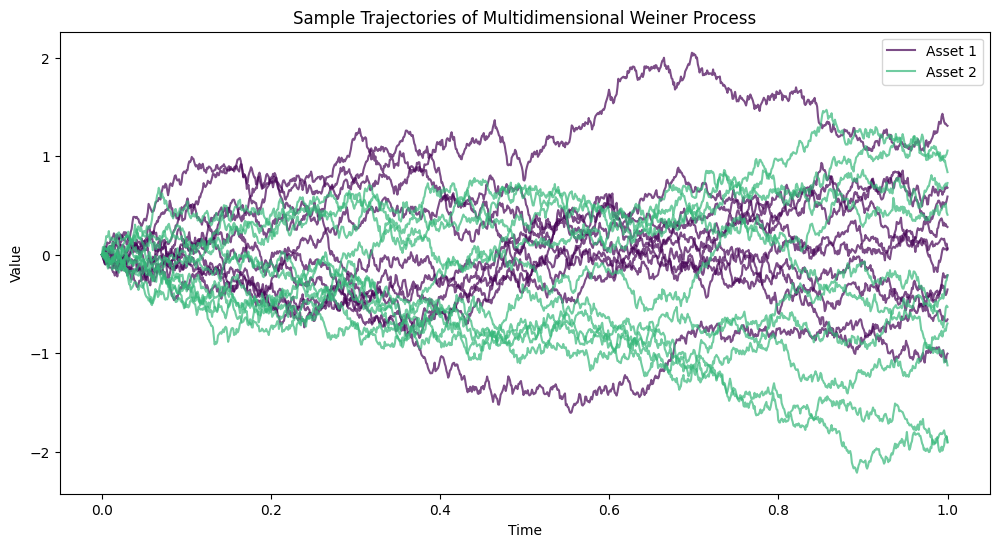

In [381]:
cmap = plt.get_cmap("viridis")

plt.figure(figsize=(12, 6))
for d in range(len(x0)):
    color = cmap(d/1.5) 
    for j in range(Ntraj):
        label = f'Asset {d+1}' if j == 0 else ''
        plt.plot(ts, trajectories_wien[j, :, d],color=color, label=label, alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Sample Trajectories of Multidimensional Weiner Process')
plt.legend()
plt.show()

In [382]:
# Геометрическое броуновское движение для 2 активов

x0 = np.array([100, 150]) 
ts = np.linspace(0, 1, 1000) 
Ntraj = 5 
mu = np.array([0.05, 0.03]) 
sigma = np.array([0.2, 0.25]) 

model = GBMModelMultivar(mu=mu, sigma=sigma)

trajectories_gbm = model.simulate(x0, ts, Ntraj)

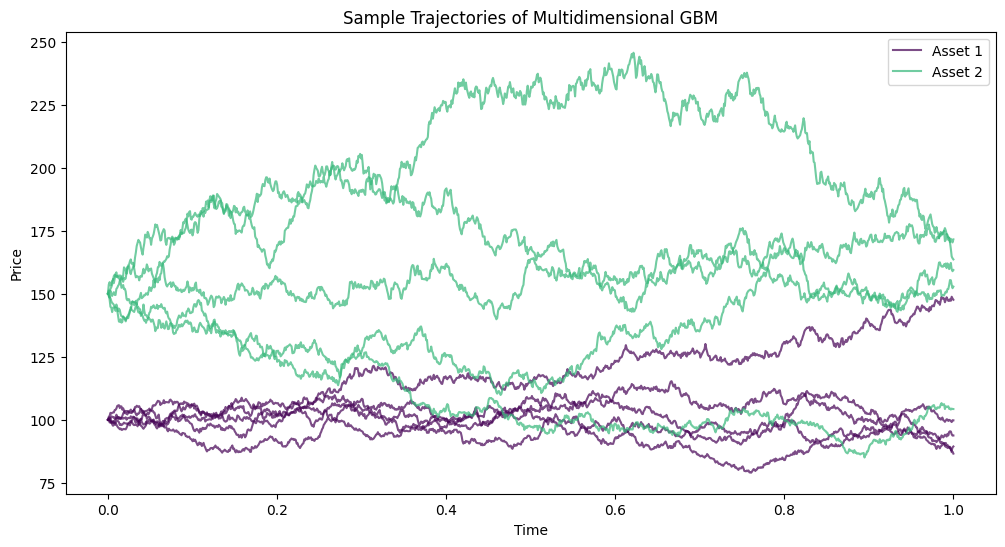

In [383]:
cmap = plt.get_cmap("viridis")

plt.figure(figsize=(12, 6))
for d in range(len(x0)):
    color = cmap(d/1.5)  # значение от 0 до 1
    for j in range(Ntraj):
        label = f'Asset {d+1}' if j == 0 else ''
        plt.plot(ts, trajectories_gbm[j, :, d],color=color, label=label, alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Sample Trajectories of Multidimensional GBM')
plt.legend()
plt.show()

#### (Приближённая) Функция ценности

Функция ценности имеет метод для оценки условного матожидания и метод для обучения и предсказания. Практически полностью повторяет sklearn, но с дополнительной обёрткой иногда удобнее.

In [384]:
class ValueFunction:

    def __init__(self):
        self.model = sklin.LinearRegression()

    def fit(self,X,y):
        return self.model.fit(X, y)
        
    def predict(self,X):
        return self.model.predict(X)

    def getParameters(self):
        return self.model.coef_, self.model.intercept_


In [385]:
#SOME SIMPLE TESTS, check it is working as it should

vf = ValueFunction()

xTests = np.concatenate([ np.ones([5,1]),(np.arange(0,1,1/5)[:,None]), (np.arange(0,1,1/5)[:,None])**2],axis=-1)
yTests = 0.2*(np.arange(0,1,1/5)[:,None])**3 + 0.8* (np.arange(0,1,1/5)[:,None])**2 - 2*(np.arange(0,1,1/5)[:,None]) + 3

vf.fit(xTests,yTests)

print(vf.getParameters())

(array([[ 0.    , -2.0688,  1.04  ]]), array([3.00192]))


МЕСТО ДЛЯ КОММЕНТАРИЕВ

Я выбрала модель линейной регрессии, тк она не требует больших вычислителных мощностей, быстро обучается на больших объемах данных, а также является легко интерпретируемой

#### Метод оценки опциона

Теперь реализуем сам метод оценки. Мы должны уметь вычислить как смещённую оценку, так и нижнюю. Используйте шаблон ниже.

In [386]:
import numpy as np

class OptionPricer:
    '''Base class for option pricing'''

    def __init__(self, priceModel, executionTimes, paymentFunction, discountFunction):
        '''
        Input:
        priceModel -- GBMModel serving as simulator
        paymentFunction -- function taking X (batch, d) and returning payments f(X) of shape (batch,)
        executionTimes -- times when it is possible to execute the option
        discountFunction -- function returning discounting rate based on the time (classic is e^{-r*h})
        '''
        self.priceModel = priceModel
        self.paymentFunction = paymentFunction
        self.executionTimes = np.array(executionTimes)
        self.continuationModels = [ValueFunction()] * (len(executionTimes) - 2)
        self.discountFunction = discountFunction

    def computeHighBiasEstimator(self, x0, r, Ntrajs):
        '''
        Trains value functions and computes highBias estimator of the price
        Input:
        Ntrajs -- number of trajectories to sample
        Returns:
        priceEstimate, priceStdDev -- price estimation and estimated standard deviation
        '''
        trajs = self.priceModel.simulate(x0, self.executionTimes, Ntrajs)
        ts = np.diff(self.executionTimes)
        
        y_k = self.paymentFunction(trajs[:, -1, :])
        
        for t in reversed(range(1, len(self.executionTimes) - 1)):
            xk = trajs[:, t, :]
            model = self.continuationModels[t - 1]
            model.fit(xk, y_k)
            vk = model.predict(xk)
            
            y_k = np.maximum(self.paymentFunction(xk), self.discountFunction(vk, ts[t - 1], r))
        
        return np.mean(y_k), np.std(y_k)

    def computeLowEstimator(self, x0, r, Ntrajs):
        '''
        Computes low estimate of the price based on trained value functions and new sampled test set of trajectories
        Input:
        Ntrajs -- number of trajectories to use for estimation
        Returns:
        priceEstimateLow, priceStdDevLow -- low estimation of the price and its estimated standard deviation
        '''
        trajs = self.priceModel.simulate(x0, self.executionTimes, Ntrajs)
        ts = np.diff(self.executionTimes)
        
        y = self.paymentFunction(trajs[:, -1, :])
        
        for t in reversed(range(1, len(self.executionTimes) - 1)):
            xk = trajs[:, t, :]
            model = self.continuationModels[t - 1]
            model.fit(xk, y)
            vk = model.predict(xk)
            
            discounted = self.discountFunction(vk, ts[t - 1], r)
            paid = self.paymentFunction(xk)
            
            mask = paid > discounted
            y[mask] = self.discountFunction(paid[mask], self.executionTimes[t], r)
        
        return np.mean(y), np.std(y)


### Проведение экспериментов

Прим.: $+$ это то же, что [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))

В качестве иллюстрации метода, рассмотрим три пример с функцией выплаты $f(x) = (\max_i x_i - K)_+$ (американский max-call опцион со страйком $K=100$) для двух акций $X^1,X^2$ с начальными ценами

1. $X_0= [100,100]$;
2. $X_0= [110,110]$;
3. $X_0= [90,90]$.

Параметры модели: банковская процентная ставка $r=0.05$ годовых, для каждой акции дивиденды $\delta=0.1$ годовых, волатильность $\sigma=0.2$, истечение срока опциона $T=3$ года. Используется геометрическое Броуновское движение с параметрами $\mu=r-\delta$ и $\sigma$, шаг дискретизации $0.3$ (число разбиений равно $10$). Max-call опцион позволяет купить товар из корзины, который имеет максимальную цену в момент исполнения, по цене страйка $K$.

Для каждого из трёх сценариев проведите следующий эксперимент: посчитайте цену опциона(high-biased) для числа траекторий для обучения $N=500,1000,2000,4000,8000,16000,50000$ и вычислите для каждого из них нижнюю оценку на $N_{test}=200000$ траекториях. Постройте график с двумя кривыми цен и гауссовскими доверительными интервалами, отображающий зависимость вычисленной цены от $N$. Сделайте вывод: какой из трёх опционов дороже? Как вы считаете, почему?

Сравните вычисленные цены с ценой европейского опциона для этих трёх примеров, в чём причина того, что его цена ниже?

1) Из представленных бумаг наиболее дорогим оказался опцион второго типа. Это связано с тем, что call-опцион дает право купить актив по цене К=100 через 3 года. Так как второй опцион предоставляет такое право для более дорогих бумаг, он стоит дороже остальных.

2) Европейский опцион дает возможность его реализации только в определенную дату, а американский -- в любое время до определенного момента времени. Таким образом, американский опцион позволяет получить потенциально более высокую прибыль от его приобретения, а значит, оценивается в большую сумму.


In [387]:
#YOUR COMPUTATIONS
T = 3
execution_times = np.arange(0, T + 0.3, 0.3)

r = 0.05
delta = 0.1
sigma = 0.2
x0 = np.array([100, 100])

def discountFunction(x, delta, r):
    return np.exp(-r*(delta))*x
    
def payment(x):
    return np.maximum(np.max(x, axis=1) - 100, 0)

pricer = OptionPricer(GBMModelMultivar(r - delta, sigma), execution_times, payment, discountFunction)

In [389]:
def compute_ci(N, mean, std, confidence_level=0.95):
    z_score = norm.ppf(1 - 0.5*(1 - confidence_level))
    margin_of_error = z_score * std / np.sqrt(N)
    return mean - margin_of_error, mean + margin_of_error

In [390]:
# YOUR CHARTS
# np.random.seed(42)
data = [np.array([100, 100]), np.array([110, 110]), np.array([90, 90])]
N_list = [500, 1000, 2000, 4000, 8000, 16000, 50000]

delta = 0.1
sigma = 0.2
T = 3
ExecTime_list = np.arange(0, T + 0.3, 0.3)
r = 0.05

High_res = {}
Low_res = {}
High_ci = {}
Low_ci = {}

pricer = OptionPricer(GBMModelMultivar(r - delta, sigma), ExecTime_list, payment, discountFunction)

for x0 in data:
    
    high_estimates = []
    low_estimates = []
    high_ci_upper_bound = []
    high_ci_lower_bound = []
    low_ci_upper_bound = []
    low_ci_lower_bound = []

    for N in N_list:
        high_p, high_p_std = pricer.computeHighBiasEstimator(x0=x0, r=r, Ntrajs=N)
        low_p, low_p_std = pricer.computeLowEstimator(r=r, x0=x0, Ntrajs=200000)
        
        hp_hci, hp_lci = compute_ci(N, high_p, high_p_std)
        lp_hci, lp_lci = compute_ci(200000, low_p, low_p_std)

        high_estimates.append(high_p)
        low_estimates.append(low_p)

        high_ci_upper_bound.append(hp_hci)
        high_ci_lower_bound.append(hp_lci)
        low_ci_upper_bound.append(lp_hci)
        low_ci_lower_bound.append(lp_lci)

    High_res[tuple(x0)] = high_estimates
    Low_res[tuple(x0)] = low_estimates
    High_ci[tuple(x0)] = (high_ci_upper_bound, high_ci_lower_bound)
    Low_ci[tuple(x0)] = (low_ci_upper_bound, low_ci_lower_bound)


In [391]:
for i, x0 in enumerate(data):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=N_list,
        y=High_res[tuple(x0)],
        mode='markers+lines',
        name='Upper Price Estimate',
        line=dict(color='royalblue', dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=N_list,
        y=High_ci[tuple(x0)][0],
        mode='lines',
        name='Upper Price Estimation CI',
        line=dict(width=0),
        showlegend=True,
        fill='tonexty',
        fillcolor='rgba(0, 0, 255, 0.15)'
    ))

    fig.add_trace(go.Scatter(
        x=N_list,
        y=High_ci[tuple(x0)][1],
        mode='lines',
        name='Lower Confidence Bound',
        line=dict(width=0),
        showlegend=False,
        fill='tonexty',
        fillcolor='rgba(0, 0, 255, 0.15)'
    ))

    fig.add_trace(go.Scatter(
        x=N_list,
        y=Low_res[tuple(x0)],
        mode='markers+lines',
        name='Lower Price Estimate',
        line=dict(color='darkred', dash='dot')
    ))

    fig.add_trace(go.Scatter(
        x=N_list,
        y=Low_ci[tuple(x0)][0],
        mode='lines',
        name='Lower Price Estimation CI',
        line=dict(width=0),
        showlegend=True,
        fill='tonexty',
        fillcolor='rgba(255, 99, 71, 0.15)'
    ))

    fig.add_trace(go.Scatter(
        x=N_list,
        y=Low_ci[tuple(x0)][1], 
        mode='lines',
        name='Lower Bound for Lower Price',
        line=dict(width=0),
        showlegend=False,
        fill='tonexty',
        fillcolor='rgba(255, 99, 71, 0.15)'
    ))

    fig.update_xaxes(type='log', title_text='Number of Training Trajectories')
    fig.update_yaxes(title_text='Bermudan Option Value')

    fig.update_layout(
        title=f'Bermudan Option Valuation for Initial State: {tuple(x0)}',
        legend_title_text='Estimation Type',
        template='plotly_dark',
        width=1200,  
        height=700
    )

    fig.show()


ВАШ КОММЕНТАРИЙ И ОТВЕТЫ НА ВОПРОСЫ

Предскажем цену европейского опциона при тех же параметрах:

In [392]:
def EuroOption(gbm, x0, t, N):
    return pricer.discountFunction(np.mean(pricer.paymentFunction(gbm.simulate(x0, t, N)[:, :, -1])),r,h)

for x in data:
    md = GBMModelMultivar(r - delta, sigma)
    print(f'Цена европейского опциона (X0: {x}): {EuroOption(md, x, ExecTime_list, 40000)}')

Цена европейского опциона (X0: [100 100]): 15.378947117480271
Цена европейского опциона (X0: [110 110]): 27.1616966352311
Цена европейского опциона (X0: [90 90]): 8.521833035396181


Ураааа, конец)) почему европейский опцион дешевле американского при прочих равных условиях, написано в начале задания)